In [ ]:
from google.colab import drive
import zipfile, os

# Mount Drive
drive.mount('/content/drive')

# Unzip dataset
zip_path = '/content/drive/MyDrive/cleaned_dataset2 (2).zip'
extract_path = '/content/cleaned_dataset2'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted folders:", os.listdir(extract_path))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Extracted folders: ['cleaned_dataset2']


In [ ]:
contents = os.listdir(extract_path)
if 'cleaned_dataset2' in contents:
    base_path = os.path.join(extract_path, 'cleaned_dataset2')
else:
    raise Exception("❌ Could not locate Train/Validate/Test folders!")

print("✅ Base path set to:", base_path)


✅ Base path set to: /content/cleaned_dataset2/cleaned_dataset2


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input

# Augmentation for training
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

# Validation & test (no augmentation)
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generators
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_path, 'Train'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'Validate'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_path, 'Test'),
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 2131 images belonging to 8 classes.
Found 303 images belonging to 8 classes.
Found 616 images belonging to 8 classes.


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Load base model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Fine-tune top 50 layers
for layer in base_model.layers[:-50]:
    layer.trainable = False
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Create model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dropout(0.2),
    Dense(train_generator.num_classes, activation='softmax')
])

# Compile
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 8, 8, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,855,976 (87.19 MB)

 Trainable params: 8,226,504 (31.38 MB)

 Non-trainable params: 14,629,472 (55.81 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/best_inceptionv3_cleaned_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 739ms/step - accuracy: 0.8574 - loss: 0.4265
Epoch 1: val_accuracy improved from -inf to 0.78548, saving model to /content/drive/MyDrive/best_inceptionv3_cleaned_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 54s 813ms/step - accuracy: 0.8574 - loss: 0.4262 - val_accuracy: 0.7855 - val_loss: 0.7209
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 741ms/step - accuracy: 0.8844 - loss: 0.3296
Epoch 2: val_accuracy did not improve from 0.78548
67/67 ━━━━━━━━━━━━━━━━━━━━ 80s 783ms/step - accuracy: 0.8843 - loss: 0.3298 - val_accuracy: 0.7822 - val_loss: 0.6941
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.8889 - loss: 0.3277
Epoch 3: val_accuracy improved from 0.78548 to 0.79868, saving model to /content/drive/MyDrive/best_inceptionv3_cleaned_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 86s 851ms/step - accuracy: 0.8888 - loss: 0.3277 - val_accuracy: 0.7987 - val_loss: 0.6284
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.9204 - loss: 0.2457
Epoch 4: val_accuracy did not improve from 0.79868
67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 829ms/step - accuracy: 0.9203 - loss: 0.2457 - val_accuracy: 0.7789 - val_loss: 0.6750
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.9189 - loss: 0.2471
Epoch 5: val_accuracy did not improve from 0.79868
67/67 ━━━━━━━━━━━━━━━━━━━━ 53s 793ms/step - accuracy: 0.9190 - loss: 0.2468 - val_accuracy: 0.7954 - val_loss: 0.7379
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.9201 - loss: 0.2117
Epoch 6: val_accuracy improved from 0.79868 to 0.82178, saving model to /content/drive/MyDrive/best_inceptionv3_cleaned_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 56s 837ms/step - accuracy: 0.9201 - loss: 0.2117 - val_accuracy: 0.8218 - val_loss: 0.7077
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.9468 - loss: 0.1588
Epoch 7: val_accuracy improved from 0.82178 to 0.83498, saving model to /content/drive/MyDrive/best_inceptionv3_cleaned_model.h5


67/67 ━━━━━━━━━━━━━━━━━━━━ 59s 876ms/step - accuracy: 0.9467 - loss: 0.1593 - val_accuracy: 0.8350 - val_loss: 0.6365
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.9470 - loss: 0.1620
Epoch 8: val_accuracy did not improve from 0.83498
67/67 ━━━━━━━━━━━━━━━━━━━━ 55s 824ms/step - accuracy: 0.9471 - loss: 0.1619 - val_accuracy: 0.8284 - val_loss: 0.6637


In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {acc*100:.2f}%")


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.7684 - loss: 0.7680
✅ Test Accuracy: 83.12%


20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 733ms/step


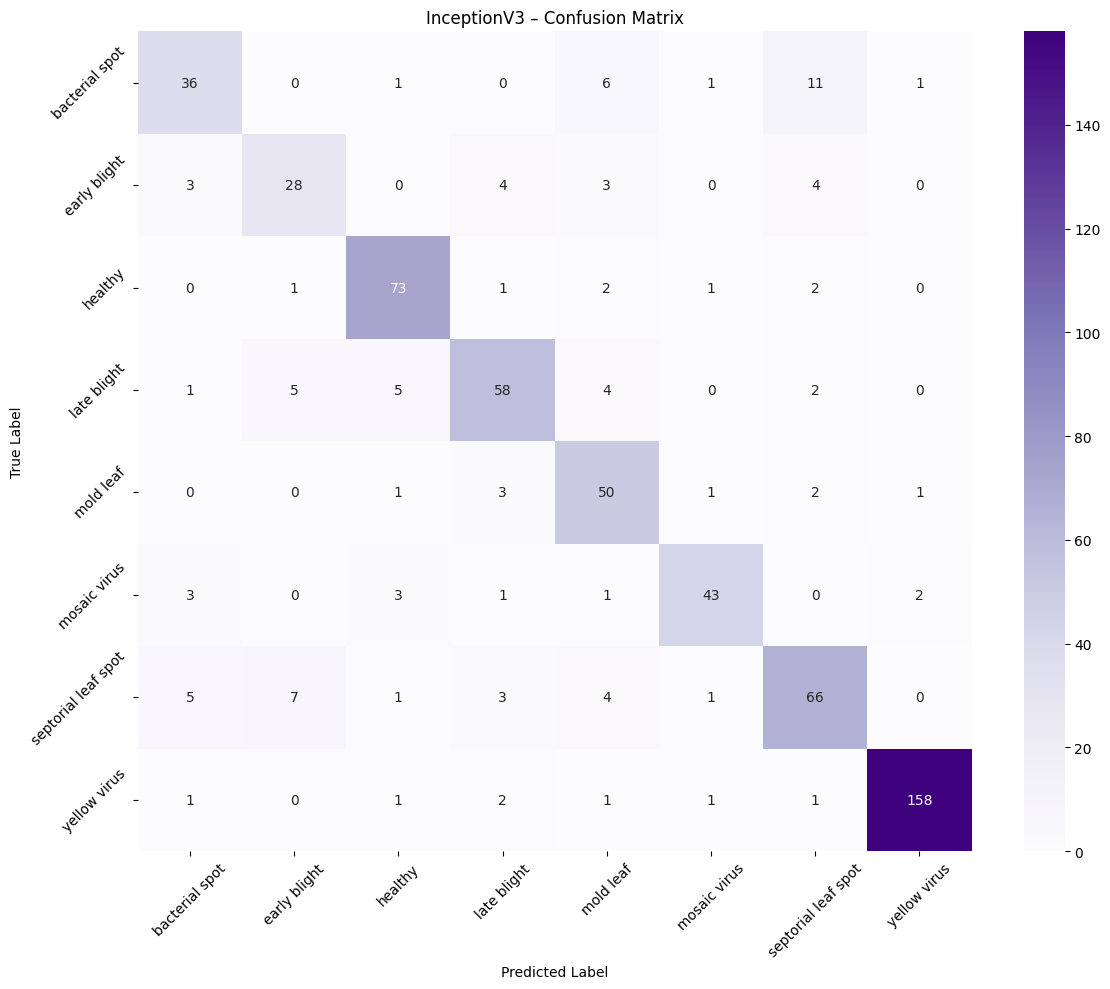

Classification Report:

                     precision    recall  f1-score   support

     bacterial spot       0.73      0.64      0.69        56
       early blight       0.68      0.67      0.67        42
            healthy       0.86      0.91      0.88        80
        late blight       0.81      0.77      0.79        75
          mold leaf       0.70      0.86      0.78        58
       mosaic virus       0.90      0.81      0.85        53
septorial leaf spot       0.75      0.76      0.75        87
       yellow virus       0.98      0.96      0.97       165

           accuracy                           0.83       616
          macro avg       0.80      0.80      0.80       616
       weighted avg       0.83      0.83      0.83       616



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("InceptionV3 – Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))


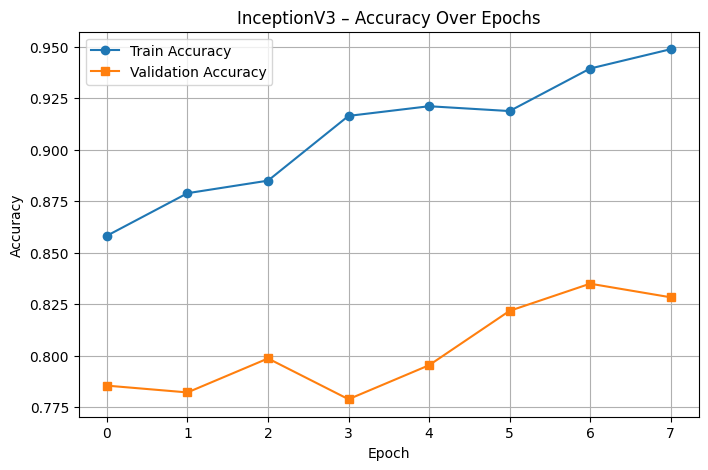

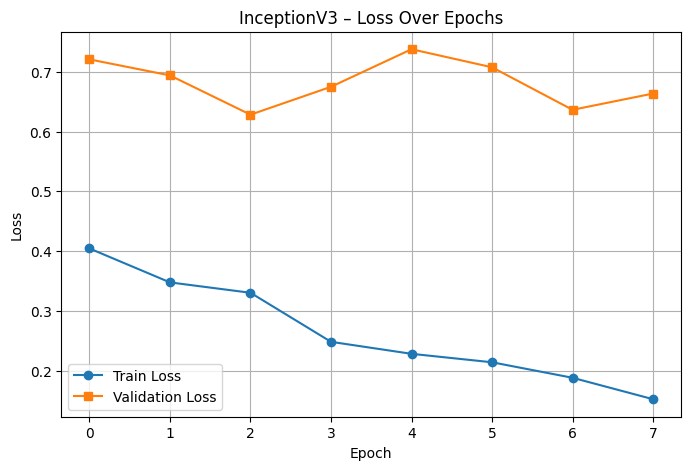

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('InceptionV3 – Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('InceptionV3 – Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
model.save('/content/drive/MyDrive/inceptionv3_cleaned_final_model.h5')
print("✅ InceptionV3 final model saved to Google Drive.")


✅ InceptionV3 final model saved to Google Drive.
